## Crazyflie Simulator: LQG 

States is a 3DOF state vector. Rotations are around the body y-axis, positions and velocities in world coordinates, and angular velocity in body-attached rotated coordinates. 

#### boilerplate import code

In [1]:
%config InlineBackend.figure_format='retina' # make plots high resolution

import matplotlib.pyplot as plt
import numpy as np
from numpy import array, sin, cos
from random import gauss # random number generator with a normal distribution. arguments: mean, stddev
# debugging: insert a BK() in your code to pause execution there and get a prompt
# in debugging environment (PDB), you can enter normal python commands and see output, with 
# exception for these single-character commands: (q)uit, (c)ontinue, (s)tep into, (n)ext line, (u)p
# NOTE: if you try to run a different cell while in the debugger you will have to Kernel...Restart 
import pdb; BK = pdb.set_trace

import control as ct
# matlab-like structs for convenient access:
class Bunch(dict): 
    def __init__(self): self.__dict__ = self

#### constants

In [2]:
dt = 1/2000.

p = Bunch() # parameters bunch
p.h = 0.01 # height of body [m]
p.l = 0.06 # length of body [m]
p.J = 1.7e-5 # estimate [kgm^2] http://mikehamer.info/assets/papers/Crazyflie%20Modelling.pdf 
p.m = 30e-3 #mass [kg]
p.g = 9.81 # [ms^-2]
p.b = 6.6e-3 # air drag [Nsm^-1]
p.pos_desired = array((.01, 0.8)) # [x_world, z_world]
p.sensor_noise_std = array((.005, .002, .05)) # [gyro, time-of-flight, optic flow]

#### Simulation: (full, nonlinear) dynamics and sensor functions
The main dynamics function returns the derivative of the state vector at each time step. 

In [3]:
def R(theta):
    # 2D rotation matrix, vworld = R @ vbody and vbody = R.T @ vworld
    return array((( cos(theta), sin(theta)), 
                  (-sin(theta), cos(theta)))) 
def simulate_dynamics(q, u, p):
    thetay = q[0]
    thetadoty = q[1]
    v_world = q[[3, 5]]
    
    # forces in world frame: [f_x, f_z] 
    f_g = (0, -p.m * p.g) # gravity
    f_z = R(thetay) @ (0, u[0] + p.m * p.g) 
    f_d = -p.b * R(thetay) @ v_world
    f = f_g + f_z + f_d
    
    # torques around body y-axis: [tau_y]
    tauy = u[1] 

    # calculate derivatives
    thetadotdoty = 1/p.J * (tauy - 0) # in 3D this would be J*thetadotdoty = tau - omega x J omega
    vdot = 1/p.m * f
    qdot = array((thetadoty, thetadotdoty, v_world[0], vdot[0], v_world[1], vdot[1]))
    return qdot

def simulate_sensor_readings(q, p):
    thetay = q[0]
    omegay = q[1]
    v_world = q[[3, 5]]
    z = q[4]
    v_body = R(thetay).T @ v_world
    
    ### fill this in ... use gauss(0, stddev) to add white noise to sensor readings
    gyro = 0
    ToF = 0
    OF = 0
    ###
    
    return array((gyro, ToF, OF))

#### Controllers and estimators
first create linearized dynamics and observer model (matrices)

In [4]:
     # thetay,omega, x,      vx, z,vz
A = array([[0,    1, 0,       0, 0, 0], # thetay 
           [0,    0, 0,       0, 0, 0], # omega
           [0,    0, 0,       1, 0, 0], # x
           [p.g,  0, 0,-p.b/p.m, 0, 0], # vx
           [0,    0, 0,       0, 0, 1], # z
           [0,    0, 0,       0, 0, -p.b/p.m]])# vz
B = array([[0,     0], 
           [0, 1/p.J], 
           [0,     0],
           [0,     0], 
           [0,     0],
           [1/p.m, 0]])
C = array([[0,     1,  0,                  0,   0,     0], # gyro
           [0,     0,  0,                  0,   1,     0], # ToF (time-of-flight)
           [0,     1,  0,-1/p.pos_desired[1],   0,     0]])# OF (optic flow)

LQR controller

In [5]:
QQ = np.diag([1, 10, 1000, 1000, 10, 10]) #  [ty, tdoty, x, vx, z, vz]
RR = np.diag([1e2, 1e12]) # control cost [thrustz, tauy]
K = ct.lqr(A, B, QQ, RR)[0]

def lqr_controller(q, p, t):
    q_desired = array((0, 0, p.pos_desired[0], 0, p.pos_desired[1], 0)) # desired trajectory (could be time-varying)
    q_error = q_desired - q
    u = K @ q_error
    u[0] = np.clip(u[0],-0.5*p.m*p.g, 0.5*p.m*p.g) # limit maximum thrust
    return u

Kalman filter/estimator

In [12]:
def lqe(A, G, C, QN, RN):
    # function to calculate Kalman gain is not part of python-control yet
    P, E, K = control.care(A.T, C.T, G @ QN @ G.T, RN)
    return K.T, P, E 

# first we must create a "reduced" linearized model that does not include x_world 
# in the state because it is not strictly observable
# state:[thetay,omega,      vx, z, vz]
A_r = array([[0,    1,       0, 0, 0], # thetay 
             [0,    0,       0, 0, 0], # omega
             [p.g,  0,-p.b/p.m, 0, 0], # vx
             [0,    0,       0, 0, 1], # z
             [0,    0,       0, 0, -p.b/p.m]]) # vz
G_r = array([[0,     0,     0], 
             [0,     0,     1/p.J], 
             [1/p.m, 0,     0],
             [0,     0,     0], 
             [0,     1/p.m, 0]])
C_r = array([[0,     1,                   0,   0,     0],
             [0,     0,                   0,   1,     0],
             [0,     1, -1/p.pos_desired[1],   0,     0]])

# check observability
### fill this in ...


###

# process noise is your tuning knob. increase it to rely more on sensors

### fill this in 
QN = np.diag((0, 0, 0)) # [fx, fz, tauy]
###

RN = np.diag((p.sensor_noise_std)**2) # sensor noise
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]

# now create full estimator, which estimates x_world by numerically integrating vx_body
# the noisy velocity estimate means there will be drift in x_world estimate
L = np.vstack((L[:2,:], [0,0,0], L[2:,:])) # add a row of zeros to L matrix

#### Simulation
Simulation is a fixed-step numerical integrator. 

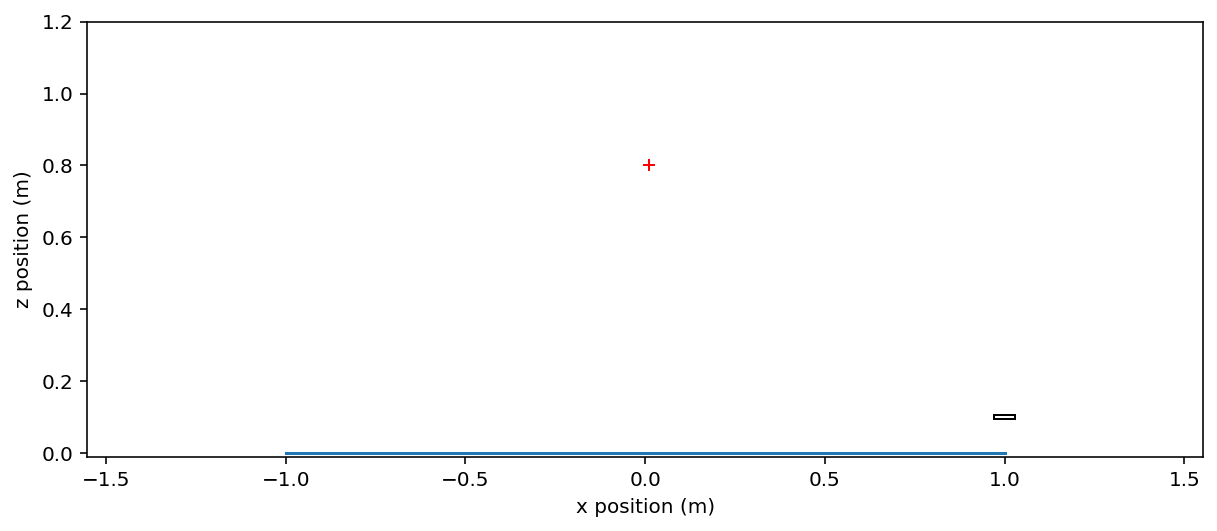

In [13]:
# initialize state and data logs 
q = array([0, 0, 1, 0, .1, 0]) # [thetay, omegay, x, vx, z, vz]
u = array([0, 0])
qhat = q # initialize estimate
t_final = 5
time = np.arange(0,t_final,dt) 
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))
y_data = np.zeros((len(time), 3))
qhat_data = np.zeros((len(time), len(q)))

# simulate
for idx, t in enumerate(time):
    
    ### fill this in 
    y = 0
    qhatdot = 0 # Kalman Filter estimate dynamics
    qhat = qhat + dt * qhatdot
    u = 0; 
    q = q + dt * 0
    ###
    
    u_data[idx,:] = u
    q_data[idx,:] = q
    y_data[idx,:] = y
    qhat_data[idx,:] = qhat

def plotfly(x, z, theta, p, color='k'):
    h = p.l/2; v = p.h/2 
    points = array(((h, h, -h, -h, h), (v, -v, -v, v, v)))
    rotated_points = R(theta) @ points 
    plt.plot(rotated_points[0,:] + x, rotated_points[1,:] + z, color=color, lw=1)
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
plt.plot(qhat_data[:,2], qhat_data[:,4], 'grey', lw=1) # trajectory
for q in qhat_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p, color='grey')
for q in q_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');


Text(0, 0.5, '$\\tau_y$ ($\\mu$Nm)')

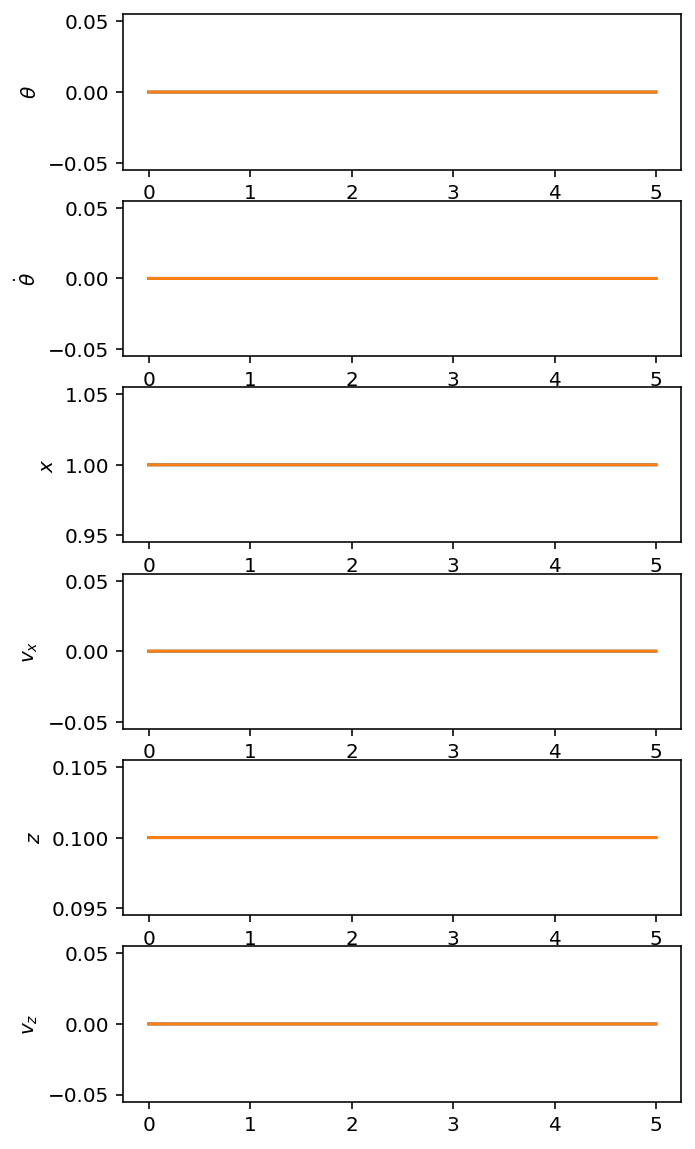

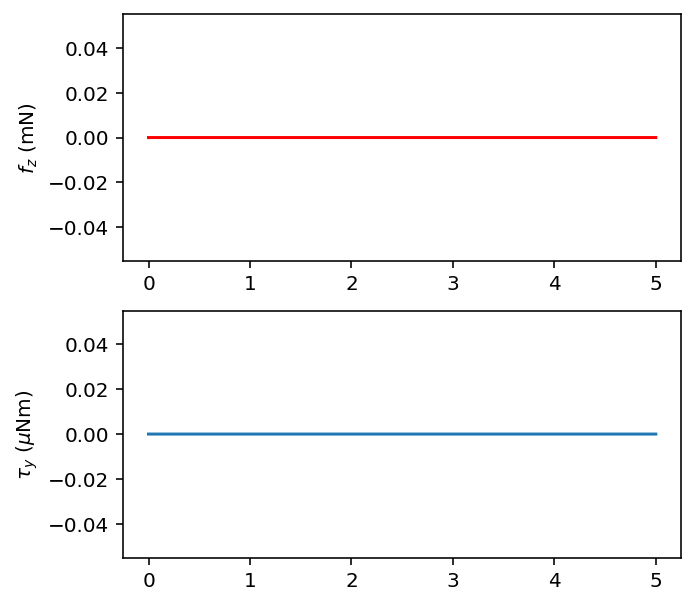

In [14]:
plt.figure(figsize=(5,10))
ylabels = (r'$\theta$', r'$\dot\theta$', r'$x$', r"$v_x$", r'$z$', r"$v_z$")
for idx in range(6):
    plt.subplot(6,1,idx+1)
    plt.plot(time, qhat_data[:,idx], time, q_data[:,idx])
    plt.ylabel(ylabels[idx])

plt.figure(figsize=(5,5))
f_z, tau_y = u_data.T
ylabels = (r'$f_z$ (mN)', r'$\tau_y$ ($\mu$Nm)')
plt.subplot(2,1,1)
plt.plot(time, u_data[:,0]*1e3, 'r')
plt.ylabel(ylabels[0])
plt.subplot(2,1,2)
plt.plot(time, u_data[:,1]*1e6)
plt.ylabel(ylabels[1])

